# Aurora Regridding, Testing, Visualization

In [1]:
import os
import sys

sys.path.append('../')

print(os.getcwd())
print(os.listdir())

/home/jgib124/aurora/aurora/afwerx
['serve.py', 'tile_server_process.ipynb', '__pycache__', 'aurora_regridding_process.ipynb', 'visualize.py', 'ssd1', 'flask_server.py', 'configs', 'tile_server.py', 'key.pem', 'tiles', 'cert.pem', 'aurora_inference_simple.py']


In [2]:
import yaml
import os
from argparse import ArgumentParser
from PIL import Image
import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib
from datetime import datetime
from io import BytesIO
import boto3
from botocore.exceptions import ClientError
import ast
import xesmf as xe
from cartopy import crs as ccrs, feature as cfeature


from inference.generate_outputs import generate_outputs
from data.era5_download import download_era5, make_batch
from tile_server import save_tile, tile_into_folders

from aurora import Aurora

/home/jgib124/miniconda3/envs/aurora_test/lib/python3.11/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/home/jgib124/miniconda3/envs/aurora_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wasabi: 
	Endpoint:  https://s3.wasabisys.com/
	Bucket:  aa-archiver
IDrive: 
	Endpoint:  https://l5l2.va.idrivee2-56.com
	Bucket:  archive-mosaics


## Batch Preparation

In [3]:
print(os.getcwd())
print(os.listdir())

/home/jgib124/aurora/aurora/afwerx
['serve.py', 'tile_server_process.ipynb', '__pycache__', 'aurora_regridding_process.ipynb', 'visualize.py', 'ssd1', 'flask_server.py', 'configs', 'tile_server.py', 'key.pem', 'tiles', 'cert.pem', 'aurora_inference_simple.py']


In [4]:
config_path = os.path.join(os.getcwd(), "configs", "configs.yml")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

print(config.keys())

dict_keys(['data', 'inference'])


In [5]:
# static_path, surface_path, atmos_path = download_era5(config['data']['era5'])

# print("Static Path: ", static_path)
# print("Surface Path: ", surface_path)
# print("Atmospheric Path: ", atmos_path)

In [6]:
# # Create batch, (step - 1) >= 0
# print("Making batch...")
# batch = make_batch(static_path, surface_path, atmos_path, 1)

## Load Model & Inference

In [7]:
# # Load model
# model_name = config['inference']['model']
# model_checkpoint = config['inference']['checkpoint']
# use_lora = config['inference']['use_lora']

# print("Loading model...")
# model = Aurora(use_lora=use_lora)
# model.load_checkpoint(model_name, model_checkpoint)
# print("Model loaded!")

In [8]:
# steps = config['inference']['steps']
# variable = config['inference']['variable']

# print("Generating outputs...")
# preds = generate_outputs(model, batch, steps=steps)
# print("\nOutputs generated!")
# print(type(preds), type(preds[0])) # List of batches for each pred step

# print("\nSurface Vars: ")
# print(preds[0].surf_vars.keys())
# print("Tensor: ", preds[0].surf_vars['2t'].shape)

# print("\nStatic Vars: ")
# print(preds[0].static_vars.keys())
# print("Tensor: ", preds[0].static_vars['z'].shape)

# print("\nAtmos Vars: ")
# print(preds[0].atmos_vars.keys())
# print("Tensor: ", preds[0].atmos_vars['u'].shape)

In [9]:
# # Print Metadata information
# lats = preds[0].metadata.lat
# lons = preds[0].metadata.lon
# times = preds[0].metadata.time
# atmos_levels = preds[0].metadata.atmos_levels
# rollout_step = preds[0].metadata.rollout_step

# print("Metadata: ")
# print("Lat: ", lats[0], lats[-1])
# print("Lon: ", lons[0], lons[-1])
# print("Time: ", times[0], times[-1])
# print("Atmos Levels: ", atmos_levels)
# print("Rollout Step: ", rollout_step)

# aurora_preds = preds[0]

### Read in ERA5 data

In [10]:
# era_path = 'tiles/era5_xr_dataset.nc'

# ds_era5 = xr.open_dataset(era_path).sel(batch=0, history=0)

# ds_era5

## Read in raw Aurora predictions

In [11]:
# aurora_path = "tiles/aurora_predictions_raw_multitime.nc"

# aurora_preds = xr.open_dataset(aurora_path).sel(batch=0, history=0)

# aurora_preds

In [12]:
# print(ds_era5.time) # 010600 to 010718
# print("\n\n")
# print(aurora_preds.time) # 010800 to 100918

In [13]:
# Concatenate the era5 and aurora preds, with a bool denoting whether the timestamp is a prediction or original data
combined_ds = xr.open_dataset('tiles/combined_era_aurora_raw_multitime.nc')

combined_ds

<xarray.Dataset> Size: 5GB
Dimensions:       (time: 16, latitude: 721, longitude: 1440, level: 13)
Coordinates:
  * latitude      (latitude) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude     (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
  * time          (time) datetime64[ns] 128B 2023-01-06 ... 2023-01-09T18:00:00
    rollout_step  (time) int64 128B ...
Data variables:
    surf_2t       (time, latitude, longitude) float32 66MB ...
    surf_10u      (time, latitude, longitude) float32 66MB ...
    surf_10v      (time, latitude, longitude) float32 66MB ...
    surf_msl      (time, latitude, longitude) float32 66MB ...
    static_z      (time, latitude, longitude) float32 66MB ...
    static_slt    (time, latitude, longitude) float32 66MB ...
    static_lsm    (time, latitude, longitude) float32 66MB ...
    atmos_t       (time, level, latitude, longitude) float32 864MB ...
    atmos_u       (time, level, latitude, longitude) float32 864MB ...
    atmos_v       (time, level, latitude, longitude) float32 864MB ...
    atmos_q       (time, level, latitude, longitude) float32 864MB ...
    atmos_z       (time, level, latitude, longitude) float32 864MB ...

## Visualize Aurora Outputs

- Atmos tensors take shape: [b, t, c, h, w] where c is the pressure level
- Surface tensors take shape: [b, t, h, w]
- Static tensors take shape: [h, w]

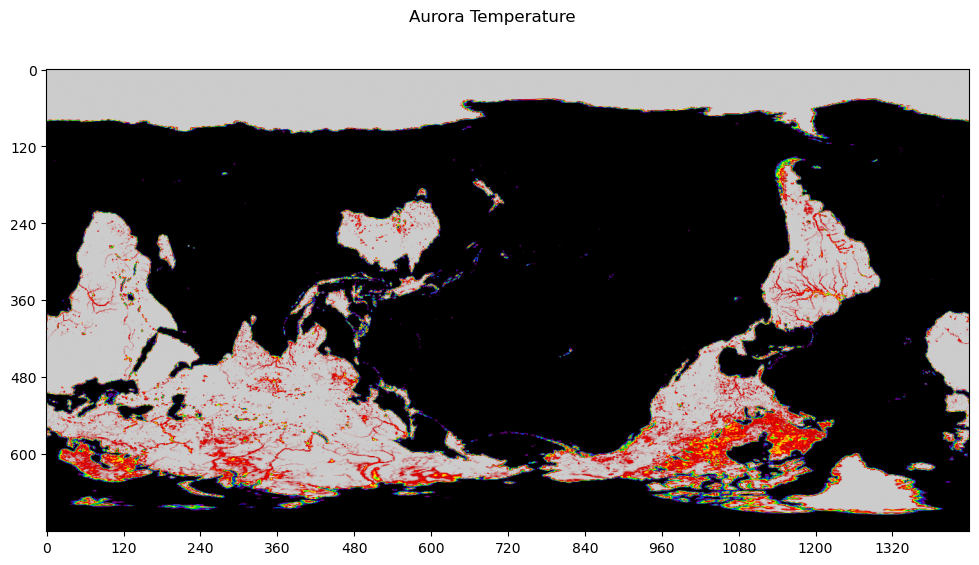

In [34]:
# step 0, var v, batch 0, time 0, level 0 (1000), y 0, x 0
temp = combined_ds['static_lsm'].isel(time=0)

# Plot the a variable without a CRS
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(temp, cmap='nipy_spectral')
ax.set_xticks(np.arange(0, 1440, 120))
ax.set_yticks(np.arange(0, 720, 120))
fig.suptitle("Aurora Temperature")
plt.show()
plt.close(fig)

del temp

In [36]:
combined_ds['latitude'].values[0], combined_ds['latitude'].values[-1]

(np.float32(-90.0), np.float32(90.0))

In [37]:
combined_ds['longitude'].values[0], combined_ds['longitude'].values[-1]

(np.float32(0.0), np.float32(359.75))

- [0, 0] appears to [Meridian, North Pole]
- Check what [0, 0] is for GFS data

### Read in GFS data to compare

In [15]:
# gfs_path = '/hdd0/archive/hail/gfs/20230101/gfs_select.t12z.pgrb2.0p25.f001.grb2'

# # Check if the path file exists
# if not os.path.exists(gfs_path):
#     raise FileNotFoundError(f"File not found: {gfs_path}")
# else:
#     print(f"File found: {gfs_path}")

In [16]:
# ds_gfs = xr.open_dataset(gfs_path, engine='cfgrib', backend_kwargs={'errors': 'ignore'})

# gfs_temp = ds_gfs['t2m']

# # Plot the a variable without a CRS
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(gfs_temp, cmap='nipy_spectral')
# ax.set_xticks(np.arange(0, 1440, 120))
# ax.set_yticks(np.arange(0, 720, 120))
# fig.suptitle("GFS Temperature")
# plt.show()
# plt.close(fig)

# # Delete the dataset
# ds_gfs.close()
# gfs_temp.close()

## Request & Visualize MyRadar Mosaic

In [17]:
idrive_endpoint = os.environ['IDRIVE_ENDPOINT']
idrive_bucket   = os.environ['IDRIVE_BUCKET']

idrive_secret   = os.environ['IDRIVE_ACCESS_SECRET']
idrive_key      = os.environ['IDRIVE_ACCESS_KEY']

print("IDrive: ")
print("\tEndpoint: ", idrive_endpoint)
print("\tBucket: ", idrive_bucket)

IDrive: 
	Endpoint:  https://l5l2.va.idrivee2-56.com
	Bucket:  archive-mosaics


In [18]:

output_path = "tiles"

dtg = datetime(2023, 1, 1, 0, 0, 0)

# Check if the mosaic dataset already exists
name = dtg.strftime('mosaic_CONUS_%Y_%m_%d_%H_%M.png')

full_path = os.path.join(output_path, name)

my_bucket = idrive_bucket
s3 = boto3.client('s3',
    endpoint_url          = idrive_endpoint,
    aws_access_key_id     = idrive_key,
    aws_secret_access_key = idrive_secret)
    
print("S3 Client Loaded: ", s3)

response = s3.list_buckets()
print("Buckets: ")
for bucket in response['Buckets']:
    print("\t", bucket['Name'])


yy, mon, dd, hh, mm, _ = dtg.strftime('%Y %m %d %H %M %s').split()
with BytesIO() as f:
    aa_path = dtg.strftime('mosaic/CONUS/%Y/%m/%d/%H/%M.png')
    print("AA File Path: ", aa_path)

    _ = s3.download_fileobj(my_bucket, aa_path, f)
    im = Image.open(f)

    out = np.asarray(im, np.uint8) # Single channel

# Get some grid information from the metadata from the PNG file.
im.getdata()
tileb = im.info['tile_bounds']
tileinfo = ast.literal_eval(tileb)
lb = tileinfo['TileMinX'] ; rb = tileinfo['TileMaxX']
bb = tileinfo['TileMinY'] ; tb = tileinfo['TileMaxY']
zoom = tileinfo['Zoom']

px = im.width // (rb - lb + 1) ; py = im.height // (tb - bb + 1)

scale = np.power(2,zoom)

xgrid = (np.float64(lb)*px + np.arange(0.,np.float64(im.width),1.0))/px
ygrid = (np.float64(bb)*py + np.arange(0.,np.float64(im.height),1.0))/py

xx,yy = np.meshgrid(xgrid,ygrid)

longitude = ( xx / scale  * 360.0) - 180.0
latitude = np.degrees(np.arctan( np.sinh( np.pi * (1.0  -  2.0 * yy / scale ) ) ) )

data_vars = { 'refl':(['y', 'x'], out,
                        {'units': 'dBZ*3',
                        'long_name':'compressed radar mosaic'})}
coords = {'longitude': (['y', 'x'], longitude),
            'latitude': (['y', 'x'], latitude)}

attrs = { 'description' : 'MyRadar mosaic' }

myradar_mosaic = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

# Print coordinates from myradar mosaic
# Note that lat/lon is a meshgrid, with shape (y, x) for both
print("Mosaic Dims: ", myradar_mosaic.dims)
print("Mosaic Coords: ")
print(myradar_mosaic.coords)
print("Mosaic Lats: ", myradar_mosaic['latitude'].dtype, myradar_mosaic['latitude'].shape, myradar_mosaic['latitude'].values[:1], myradar_mosaic['latitude'].values[-1:])
print("Mosaic Lons: ", myradar_mosaic['longitude'].dtype, myradar_mosaic['latitude'].shape, myradar_mosaic['longitude'].values[:1], myradar_mosaic['longitude'].values[-1:])

S3 Client Loaded:  <botocore.client.S3 object at 0x7f81f3f55a50>
Buckets: 
	 archive-model
	 archive-mosaics
AA File Path:  mosaic/CONUS/2023/01/01/00/00.png
Mosaic Dims:  FrozenMappingWarningOnValuesAccess({'y': 4608, 'x': 7168})
Mosaic Coords: 
Coordinates:
    longitude  (y, x) float64 264MB -135.0 -135.0 -135.0 ... -56.27 -56.26
    latitude   (y, x) float64 264MB 55.78 55.78 55.78 ... 16.65 16.65 16.65
Mosaic Lats:  float64 (4608, 7168) [[55.77657302 55.77657302 55.77657302 ... 55.77657302 55.77657302
  55.77657302]] [[16.64671805 16.64671805 16.64671805 ... 16.64671805 16.64671805
  16.64671805]]
Mosaic Lons:  float64 (4608, 7168) [[-135.         -134.98901367 -134.97802734 ...  -56.28295898
   -56.27197266  -56.26098633]] [[-135.         -134.98901367 -134.97802734 ...  -56.28295898
   -56.27197266  -56.26098633]]


- Mosaic is on a curvilinear meshgrid, where lat/lon is individually defined for each grid point
- Lat and lon each have shape (4608, 7168)

In [19]:
myradar_mosaic

<xarray.Dataset> Size: 562MB
Dimensions:    (y: 4608, x: 7168)
Coordinates:
    longitude  (y, x) float64 264MB -135.0 -135.0 -135.0 ... -56.27 -56.26
    latitude   (y, x) float64 264MB 55.78 55.78 55.78 ... 16.65 16.65 16.65
Dimensions without coordinates: y, x
Data variables:
    refl       (y, x) uint8 33MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    description:  MyRadar mosaic

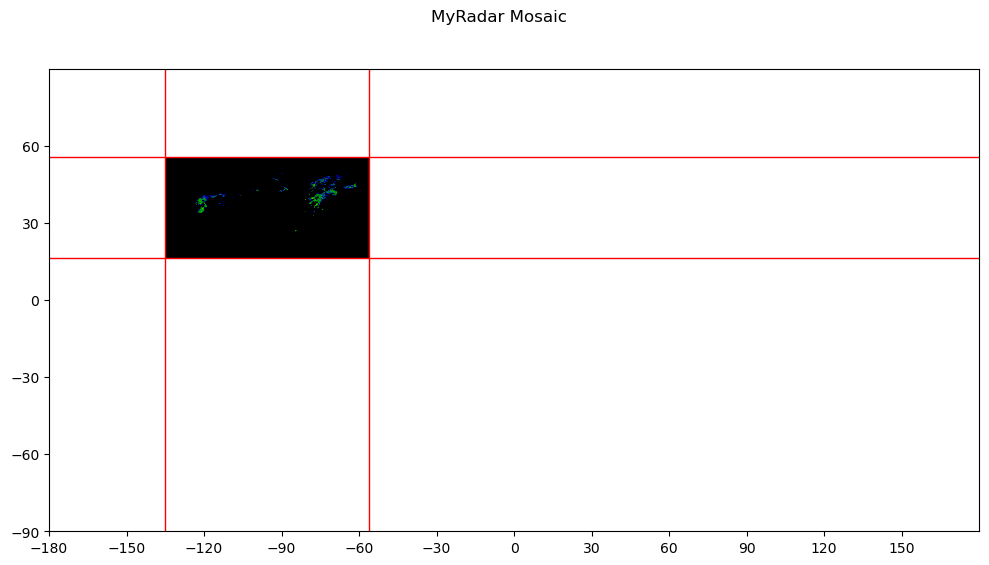

In [20]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

minlon = myradar_mosaic['longitude'].min().values
maxlon = myradar_mosaic['longitude'].max().values
minlat = myradar_mosaic['latitude'].min().values
maxlat = myradar_mosaic['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=myradar_mosaic['longitude'], y=myradar_mosaic['latitude'], s=0.01, c=myradar_mosaic['refl'], cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 180])
plt.ylim([-90, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 180, 30))
ax.set_yticks(np.arange(-90, 90, 30))
fig.suptitle("MyRadar Mosaic")
plt.show()
plt.close(fig)

### Attempt regridding with GFS data

In [21]:
# regrid_path = config['inference']['interpolation_file']

# regridder = xe.Regridder(ds_in=ds_gfs, ds_out=myradar_mosaic, method='bilinear', filename=regrid_path, reuse_weights=True)

# ds_gfs_regrid = regridder(ds_gfs)

# ds_gfs_regrid

In [22]:
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot(1, 1, 1)

# minlon = ds_gfs_regrid['longitude'].min().values
# maxlon = ds_gfs_regrid['longitude'].max().values
# minlat = ds_gfs_regrid['latitude'].min().values
# maxlat = ds_gfs_regrid['latitude'].max().values

# # Plot the coordinate locations
# plt.scatter(x=ds_gfs_regrid['longitude'], y=ds_gfs_regrid['latitude'], s=0.01, c=ds_gfs_regrid['t2m'], cmap='nipy_spectral', edgecolor='none')
# plt.xlim([-180, 180])
# plt.ylim([-90, 90])

# # Add lines for lon/lat range
# ax.axhline(y=minlat, color='r', linewidth=1)
# ax.axhline(y=maxlat, color='r', linewidth=1)
# ax.axvline(x=minlon, color='r', linewidth=1)
# ax.axvline(x=maxlon, color='r', linewidth=1)

# ax.set_xticks(np.arange(-180, 180, 30))
# ax.set_yticks(np.arange(-90, 90, 30))
# fig.suptitle("GFS Regridded - t2m")
# plt.show()
# plt.close(fig)

In [23]:
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot(1, 1, 1)

# minlon = ds_gfs_regrid['longitude'].min().values
# maxlon = ds_gfs_regrid['longitude'].max().values
# minlat = ds_gfs_regrid['latitude'].min().values
# maxlat = ds_gfs_regrid['latitude'].max().values

# # Plot the coordinate locations
# plt.scatter(x=ds_gfs_regrid['longitude'], y=ds_gfs_regrid['latitude'], s=0.01, c=ds_gfs_regrid['ustm'], cmap='nipy_spectral', edgecolor='none')
# plt.xlim([-180, 0])
# plt.ylim([0, 90])

# # Add lines for lon/lat range
# ax.axhline(y=minlat, color='r', linewidth=1)
# ax.axhline(y=maxlat, color='r', linewidth=1)
# ax.axvline(x=minlon, color='r', linewidth=1)
# ax.axvline(x=maxlon, color='r', linewidth=1)

# ax.set_xticks(np.arange(-180, 0, 30))
# ax.set_yticks(np.arange(0, 90, 30))
# fig.suptitle("GFS Regridded - U Wind")
# plt.show()
# plt.close(fig)

### Attempt regridding Aurora data

In [24]:
# Attempt to pad Aurora
# https://docs.xarray.dev/en/stable/generated/xarray.Dataset.pad.html
# aurora_preds_padded = combined_ds.pad({"latitude": (0, 1)}, mode='symmetric')

# # Reassign latitude values from [90, -89.75] to [90.0, -90.0]
# new_lats = np.linspace(90.0, -90.0, 721)

# print("New Lats: ", new_lats[:5], new_lats[-5:])

# aurora_preds_padded = aurora_preds_padded.assign_coords(latitude=new_lats)

aurora_preds_padded = combined_ds

aurora_preds_padded

<xarray.Dataset> Size: 5GB
Dimensions:       (time: 16, latitude: 721, longitude: 1440, level: 13)
Coordinates:
  * latitude      (latitude) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude     (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
  * time          (time) datetime64[ns] 128B 2023-01-06 ... 2023-01-09T18:00:00
    rollout_step  (time) int64 128B ...
Data variables:
    surf_2t       (time, latitude, longitude) float32 66MB ...
    surf_10u      (time, latitude, longitude) float32 66MB ...
    surf_10v      (time, latitude, longitude) float32 66MB ...
    surf_msl      (time, latitude, longitude) float32 66MB ...
    static_z      (time, latitude, longitude) float32 66MB ...
    static_slt    (time, latitude, longitude) float32 66MB ...
    static_lsm    (time, latitude, longitude) float32 66MB ...
    atmos_t       (time, level, latitude, longitude) float32 864MB ...
    atmos_u       (time, level, latitude, longitude) float32 864MB ...
    atmos_v       (time, level, latitude, longitude) float32 864MB ...
    atmos_q       (time, level, latitude, longitude) float32 864MB ...
    atmos_z       (time, level, latitude, longitude) float32 864MB ...

In [25]:
# # Compare shape of GFS and Aurora
# print("Shape: ")
# print("\tGFS: ", ds_gfs['t2m'].shape)
# print("\tAurora: ", aurora_preds['atmos_t'].shape)
# print("\tAurora Padded: ", aurora_preds_padded['atmos_t'].shape)

# # Compare latitude ranges of GFS and Aurora
# print("Latitudes: ")
# print("\tGFS: ")
# print("\t\t", ds_gfs['latitude'].min().values, ds_gfs['latitude'].max().values)
# print("\t\t", ds_gfs['latitude'].values[:5], ds_gfs['latitude'].values[-5:])

# print("\tAurora: ")
# print("\t\t",aurora_preds['latitude'].min().values, aurora_preds['latitude'].max().values)
# print("\t\t", aurora_preds['latitude'].values[:5], aurora_preds['latitude'].values[-5:])

# print("\tAurora Padded: ")
# print("\t\t", aurora_preds_padded['latitude'].min().values, aurora_preds_padded['latitude'].max().values)
# print("\t\t", aurora_preds_padded['latitude'].values[:5], aurora_preds_padded['latitude'].values[-5:])


In [26]:
regrid_path = config['inference']['interpolation_file']

aurora_regridder = xe.Regridder(ds_in=aurora_preds_padded, ds_out=myradar_mosaic, method='bilinear', filename=regrid_path, reuse_weights=True)

ds_aurora_regrid = aurora_regridder(aurora_preds_padded)

ds_aurora_regrid 

<xarray.Dataset> Size: 153GB
Dimensions:       (time: 16, y: 4608, x: 7168, level: 13)
Coordinates:
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
  * time          (time) datetime64[ns] 128B 2023-01-06 ... 2023-01-09T18:00:00
    rollout_step  (time) int64 128B 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 8
    longitude     (y, x) float64 264MB -135.0 -135.0 -135.0 ... -56.27 -56.26
    latitude      (y, x) float64 264MB 55.78 55.78 55.78 ... 16.65 16.65 16.65
Dimensions without coordinates: y, x
Data variables:
    surf_2t       (time, y, x) float32 2GB 276.7 276.7 276.7 ... 306.3 306.3
    surf_10u      (time, y, x) float32 2GB 14.04 14.05 14.05 ... 1.321 1.324
    surf_10v      (time, y, x) float32 2GB 2.229 2.242 2.255 ... -1.551 -1.56
    surf_msl      (time, y, x) float32 2GB 9.975e+04 9.975e+04 ... 1.009e+05
    static_z      (time, y, x) float32 2GB -4.459 -4.465 ... 1.244e+03 1.247e+03
    static_slt    (time, y, x) float32 2GB 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0
    static_lsm    (time, y, x) float32 2GB 0.0 0.0 0.0 ... 0.9963 0.9965 0.9968
    atmos_t       (time, level, y, x) float32 27GB 276.4 276.4 ... 208.5 208.5
    atmos_u       (time, level, y, x) float32 27GB 14.06 14.06 ... -8.394 -8.392
    atmos_v       (time, level, y, x) float32 27GB 2.241 2.253 ... -5.225 -5.224
    atmos_q       (time, level, y, x) float32 27GB 0.003943 ... 2.888e-06
    atmos_z       (time, level, y, x) float32 27GB -198.8 -199.4 ... 2.022e+05
Attributes:
    regrid_method:  bilinear

In [27]:
# Save regridded output
ds_aurora_regrid.to_netcdf("tiles/combined_era_aurora_regridded.nc")

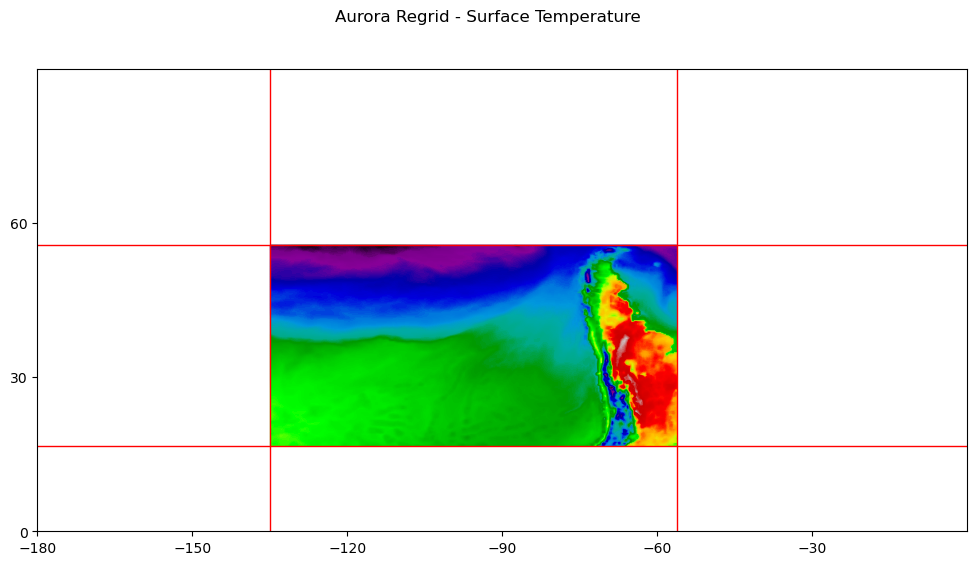

In [30]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selected_title = "Aurora Regrid - Surface Temperature"
selected_ds = ds_aurora_regrid['surf_2t'].isel(time=0)

minlon = ds_aurora_regrid['longitude'].min().values
maxlon = ds_aurora_regrid['longitude'].max().values
minlat = ds_aurora_regrid['latitude'].min().values
maxlat = ds_aurora_regrid['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=ds_aurora_regrid['longitude'], y=ds_aurora_regrid['latitude'], s=0.01, c=selected_ds, cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 0])
plt.ylim([0, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 0, 30))
ax.set_yticks(np.arange(0, 90, 30))
fig.suptitle(selected_title)
plt.show()
plt.close(fig)

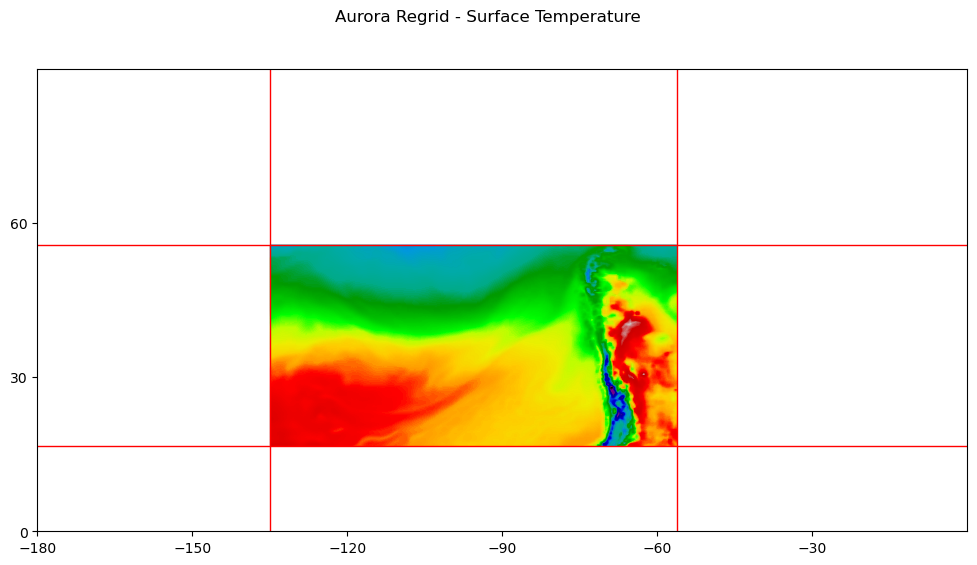

In [31]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selected_title = "Aurora Regrid - Surface Temperature"
selected_ds = ds_aurora_regrid['surf_2t'].isel(time=9)

minlon = ds_aurora_regrid['longitude'].min().values
maxlon = ds_aurora_regrid['longitude'].max().values
minlat = ds_aurora_regrid['latitude'].min().values
maxlat = ds_aurora_regrid['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=ds_aurora_regrid['longitude'], y=ds_aurora_regrid['latitude'], s=0.01, c=selected_ds, cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 0])
plt.ylim([0, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 0, 30))
ax.set_yticks(np.arange(0, 90, 30))
fig.suptitle(selected_title)
plt.show()
plt.close(fig)

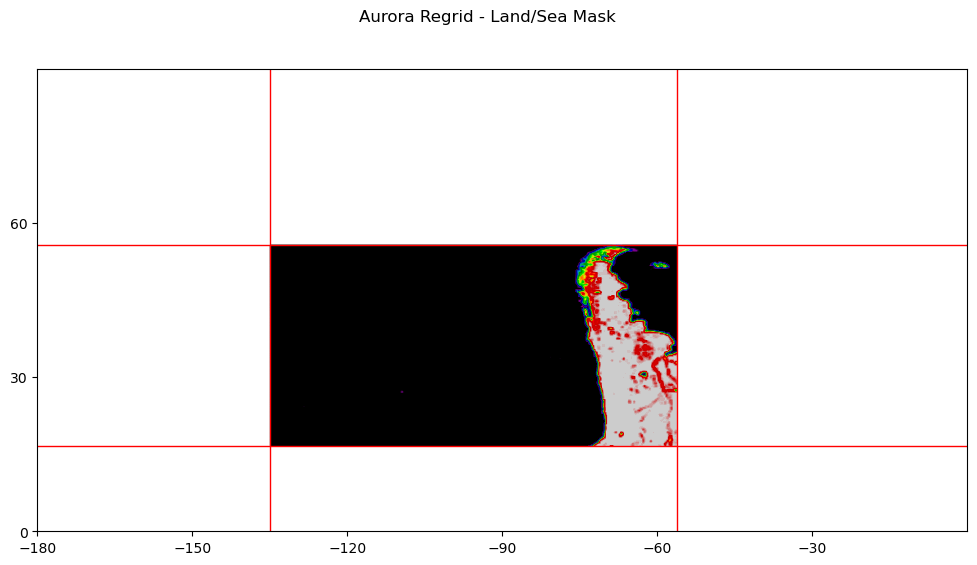

In [32]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selected_title = "Aurora Regrid - Land/Sea Mask"
selected_ds = ds_aurora_regrid['static_lsm'].isel(time=0)

minlon = ds_aurora_regrid['longitude'].min().values
maxlon = ds_aurora_regrid['longitude'].max().values
minlat = ds_aurora_regrid['latitude'].min().values
maxlat = ds_aurora_regrid['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=ds_aurora_regrid['longitude'], y=ds_aurora_regrid['latitude'], s=0.01, c=selected_ds, cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 0])
plt.ylim([0, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 0, 30))
ax.set_yticks(np.arange(0, 90, 30))
fig.suptitle(selected_title)
plt.show()
plt.close(fig)